# Understanding and Quantifying Uncertainty in Agent-Based Models for Smart City Forecasts - Kevin Minors

_This post reports on the progress of Kevin Minors' [LIDA](http://lida.leeds.ac.uk/) data science project (Oct 2018 - Apr 2019) that is part of the Data Assimilation for Agent-Based Modelling ([DUST](https://urban-analytics.github.io/dust/)) programme._

## Introduction

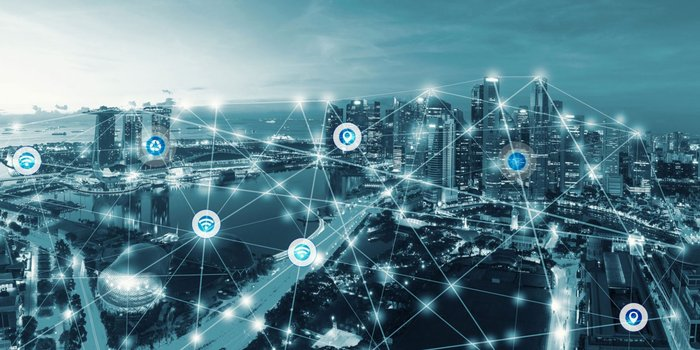

Smart cities are increasingly using data to become more efficient and sustainable. One of the difficult questions smart cities want to answer is: how do people behave? One way to solve this issue is to use agent based models. These models use simulated individuals to model the way real human behave, including interactions between individuals and interactions between individuals and the environment. 

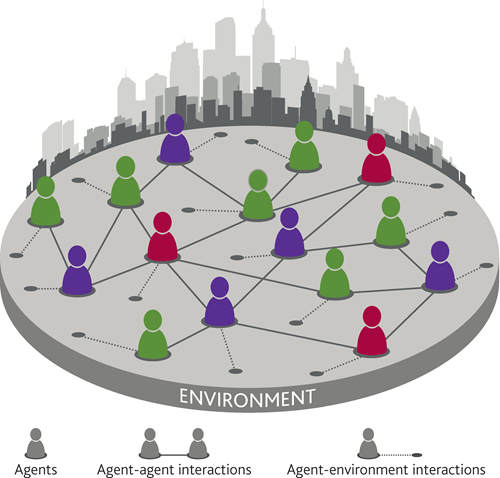

One common problem with agent based models is that, once started, they evolve independently from changes in the real world. This means they often diverge from the true state of the system. One way to overcome this challenge is to use data assimilation. This process uses observations from the real world to update the agent based model in real time to ensure it remains accurate. 

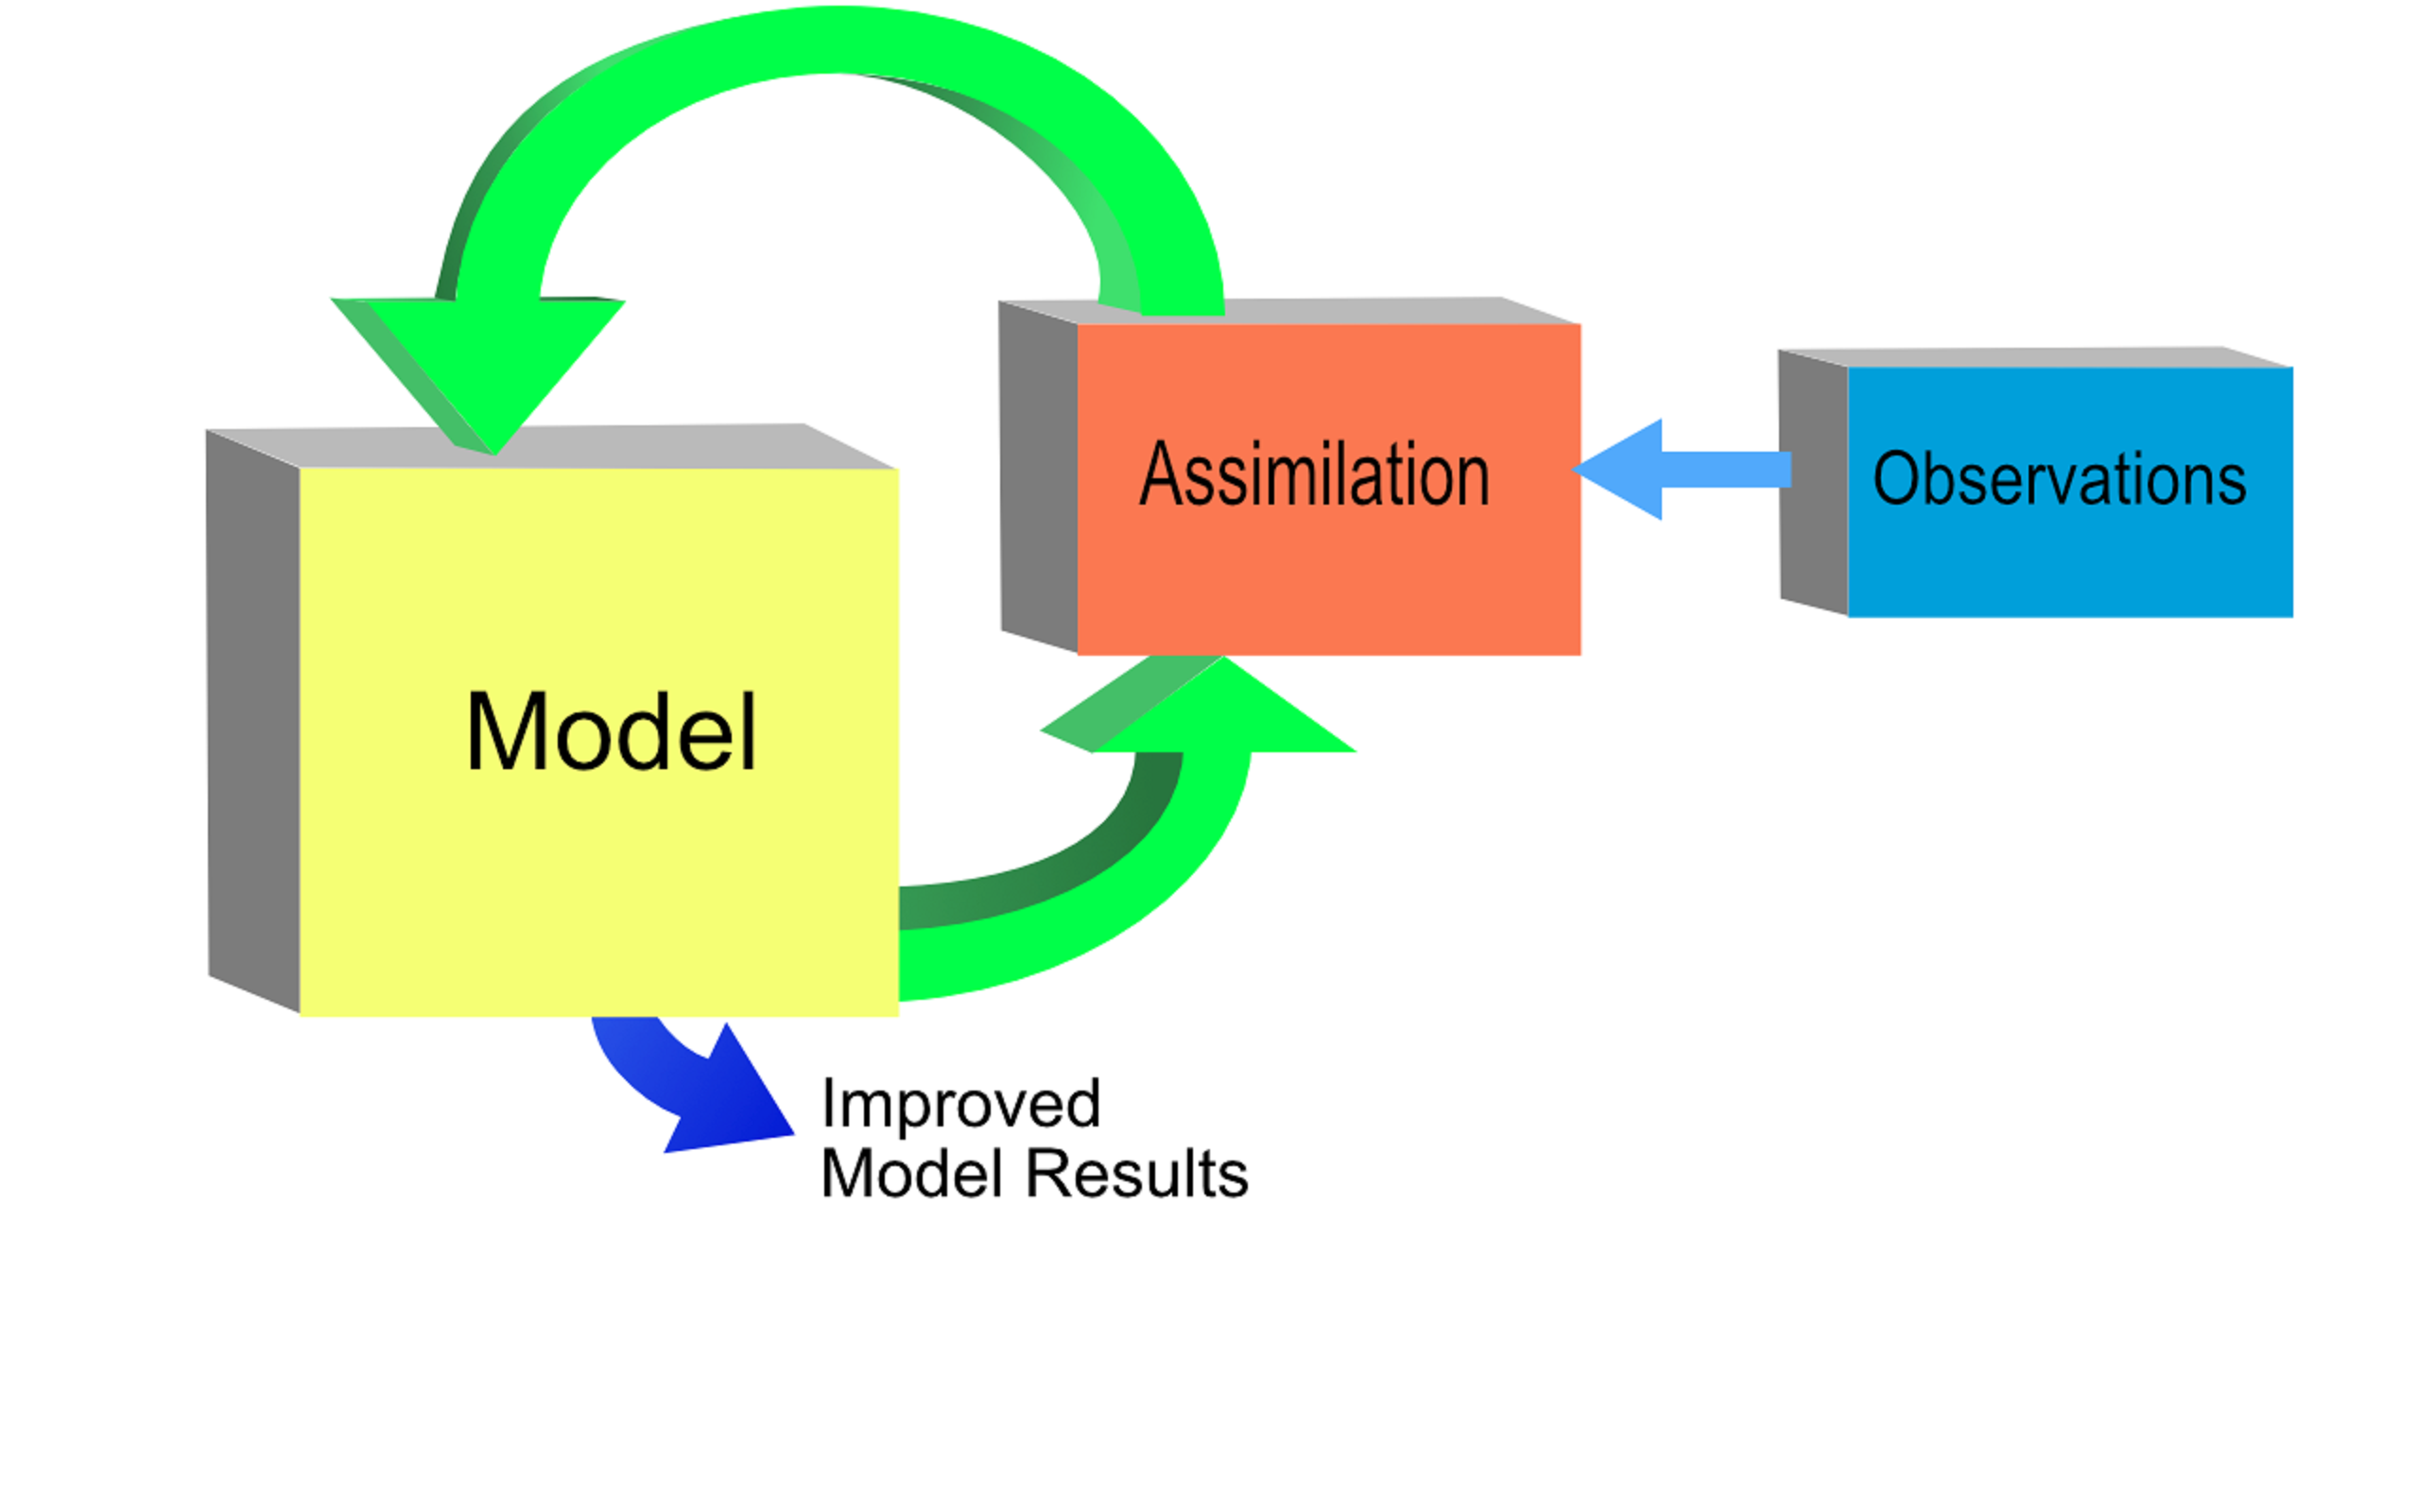

One method of data assimilation is called a particle filter. Particle filters run multiple instances of a model and evolve them forward in time. These individual models are known as 'particles'. When new observations are received from the real world, the particles are reweighted and resampled so that those that are closer to the new information are more likely to be duplicated and particles that are far away are more likely to be discarded. Below is an example of a particle filter. The dots represent the particles, the blue line represent the true state of the model, and the crosses represent the observations of the true state. 

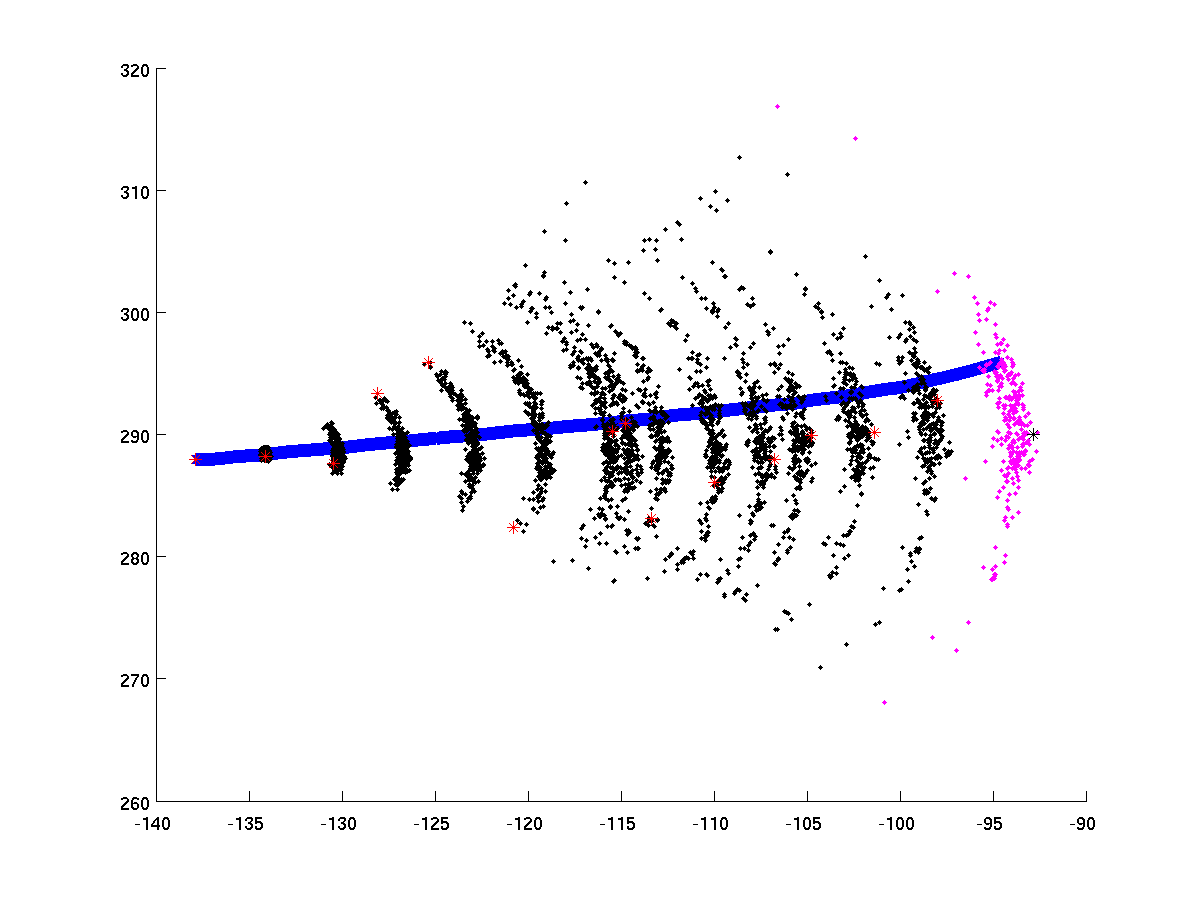

The aim of this project is to apply a particle filter to an agent based model to determine how well it can assimilate data. As we're not ready to test these methods on models of real systems yet, we run the agent-based model and record the results, which are taken as the 'reality'. When the particle filter produces results, we compare them to the results from the model recorded as 'reality'. This is called the 'identical twin experiment'.

## Adapting particle filter from R. Labbe book

The project started with background reading of ‘Kalman and Bayesian Filters in Python’ by Roger Labbe. 

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

The beginning chapters focus on simple algorithms that combine measurements from sensors and predictions from models to estimate the state of a system, known as a 'filter', and they gradually progress to more advanced filters, including a variety of Kalman filters and a particle filter. I decided to focus on the particle filter. 

The particle filter chapter in the textbook discusses the general algorithm: generate particles, predict particles forward, update the weights of the particles, resample the particles based on the weights, and then compute state estimates using the particles. The following flow diagram outlines the process of a particle filter.

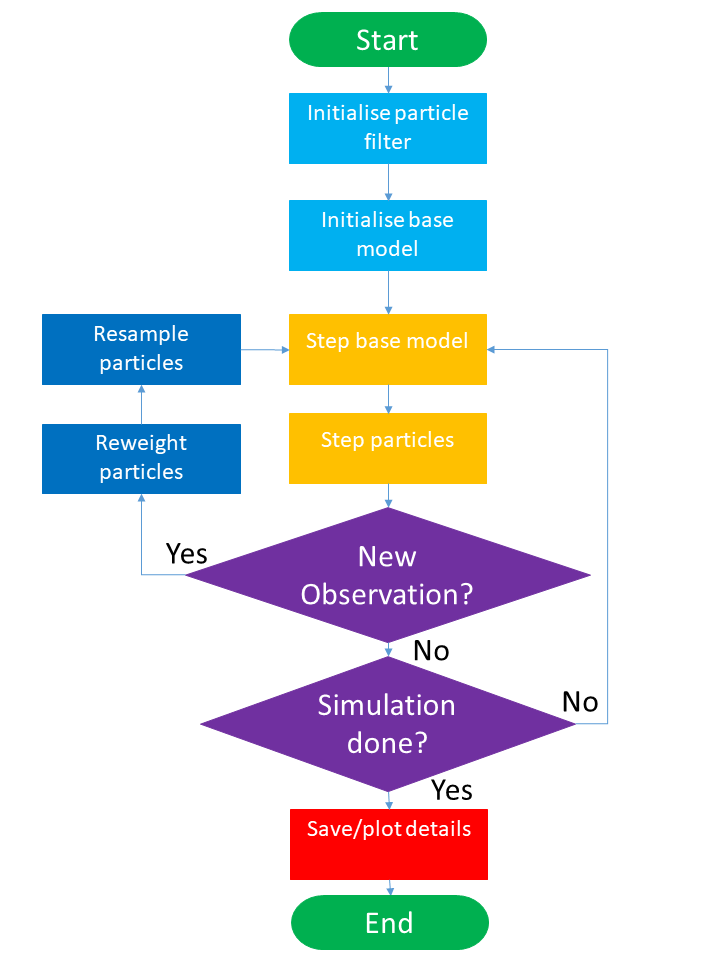

### Initialise particle filter

Begin by setting up all particle filter parameters, variables, and data structures.

### Initialise base model

Initialise the model that the particle filter will be trying to simulate. This underlying model will provide the particle filter with information on where all the individuals are, called an 'observation'. 

### Step base model

Increment the base model by allowing the model to run one step forward in time. 

### Step particles

Increment the particles by allowing them to run one step forward in time. 

### New observation

A new observation is received from the base model after a given number of time steps have passed, called a 'resample window'. This observation provides the particle filter with the lcoation of the agents in the base model. 

### Reweight particles

With the new observation, we weight the particles based on how similar they are to the observation. If a particle is very similar to the observation, we give it a large weight. If the particle is very different from the observation, we give it a small weight. 

### Resample particles

Then, using the new weights, we resample the particles. Particles with large weights are more likely to be duplicated while particles with small weights are more likely to be discarded. 

### Simulation done

Once all agents in the base model have completed the simulation, the particle filter is finished. 

### Save/plot details

We finally save and plot any results from the particle filter. 

The textbook then moves on to examples of an sequential importance resampling (SIR) particle filter and highlights the problems that occur when there are not enough particles near the target. It finishes with a comparison of the different resampling methods. 

The actual particle filter in this chapter is written for a robot moving in an environment filled with landmarks. Below is the code for this particle filter estimating the location of a robot based on distances to numerous landmarks.

## Particle filter for robot and landmarks

(_This code, which is from Roger Labbe's [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) ([Chapter 12 - Particle Filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb)) book, was used as the basis for my own particle filter code_).

final position error, variance:
	 [ 0.09280355 -0.17494662] [0.00577109 0.01313016]


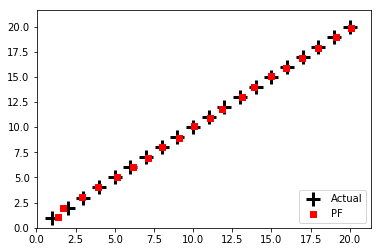

In [5]:
from numpy.random import uniform
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from numpy.random import seed

def create_uniform_particles(x_range, y_range, hdg_range, num_of_particles):
    '''
    Create Uniformly Distributed Particles
    
    PARAMETERS
     - x_range:             Interval of x values for particle locations   
     - y_range:             Interval of y values for particle locations 
     - hdg_range:           Interval of heading values for particles in radians
     - num_of_particles:    Number of particles
    
    DESCRIPTION
    Create N by 3 array to store x location, y location, and heading
    of each particle uniformly distributed. Take modulus of heading to ensure heading is 
    in range [0,2*pi).
    
    Returns particle locations and headings
    '''
    particles = np.empty((num_of_particles, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size = num_of_particles)
    particles[:, 1] = uniform(y_range[0], y_range[1], size = num_of_particles)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size = num_of_particles)
    particles[:, 2] %= 2 * np.pi
    return particles

def predict(particles, control_input, std, dt=1.):
    '''
    Predict particles
    
    PARAMETERS
     - particles:       Locations and headings of all particles
     - control_input:   Heading, x location step, and y location step to predict particles
     - std:             Standard deviation for noise added to prediction
     - dt:              Time step
     
    DESCRIPTION
    Predict particles forward one time step using control input u
    (heading, x step, y step) and noise with standard deviation std.
    '''
    num_of_particles = len(particles)
    
    # update heading
    particles[:, 2] += control_input[0] + (randn(num_of_particles) * std[0])
    particles[:, 2] %= 2 * np.pi

    # calcualte change in x and y directions
    xdist = (control_input[1] * dt) + (randn(num_of_particles) * std[1])
    ydist = (control_input[2] * dt) + (randn(num_of_particles) * std[2])
    
    # add changes to current x and y locations
    particles[:, 0] += xdist
    particles[:, 1] += ydist
    
    # uncomment below when u = (heading, velocity) to predict
    # particles using a velocity rather than an x and y change.
    #
    #dist = (u[1] * dt) + (randn(num_of_particles) * std[1])
    #particles[:, 0] += np.cos(particles[:,2])*dist
    #particles[:, 1] += np.sin(particles[:,2])*dist
    
    
def update(particles, weights, observation, sensor_std, landmarks):
    '''
    Update particle weights
    
    PARAMETERS
     - particles:    Locations and headings of all particles
     - weights:      Weights of all particles
     - observation:  Observation of distances between robot and all landmarks
     - sensor_std:   Standard deviation for error in sensor for observation
     - landmarks:    Locations of all landmarks
    
    DESCRIPTION
    Set all weights to 1. For each landmark, calculate the distance between 
    the particles and that landmark. Then, for a normal distribution with mean 
    = distance and std = sensor_std, calculate the pdf for a measurement of observation. 
    Multiply weight by pdf. If observation is close to distance, then the 
    particle is similar to the true state of the model so the pdf is close 
    to one so the weight stays near one. If observation is far from distance,
    then the particle is not similar to the true state of the model so the 
    pdf is close to zero so the weight becomes very small.   
    
    The distance variable depends on the particles while the z parameter depends 
    on the robot.
    '''
    weights.fill(1.)
    
    for i, landmark in enumerate(landmarks):
        
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, sensor_std).pdf(observation[i])
        
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    
def effective_n(weights):
    '''
    Calculate effective N
    
    PARAMETERS
     - weights:    Weights of all particles
    
    DESCRIPTION
    Calculates effective N, an approximation for the number of particles 
    contributing meaningful information determined by their weight. When 
    this number is small, the particle filter should resample the particles
    to redistribute the weights among more particles.
    
    Returns effective N.
    '''
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    '''
    Resample particles by index
    
    PARAMETERS
     - particles:    Locations and headings of all particles
     - weights:      Weights of all particles
     - indexes:      Indexes of particles to be resampled
     
    DESCRIPTION
    Resample particles and the associated weights using indexes. Reset
    weights to 1/N = 1/len(weights).
    '''
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill (1.0 / len(weights))
    
def estimate(particles, weights):
    '''
    Estimate state of system
    
    PARAMETERS:
     - particles:    Locations and headings of all particles
     - weights:      Weights of all particles
    
    DESCRIPTION
    Estimate the state of the system by calculating the mean and variance
    of the weighted particles.
    
    Returns mean and variance of the particle locations
    '''
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def run_textbook_particle_filter(num_of_particles, 
                        num_of_iterations = 20, 
                        sensor_std = .1, 
                        do_plot = True, 
                        plot_particles = False):
    '''
    Run the particle filter
    
    PARAMETERS
     - num_of_particles:     Number of particles
     - num_of_iterations:    Number of iterations for particle filter
     - sensor_std:           Standard deviation for error of sensor
     - do_plot:              Boolean variable to plot particle filter results
     - plot_particles:       Boolean variable to plot each particle
    
    DESCRIPTION
    Set locations for landmarks, particle locations, and particle weights.
    Plot individual particles initially. Set robot location. For each
    iteration, increment the robot location, take observation with noise 
    for distance between robot and landmarks, predict particles forward, 
    update particle weights. If effective N is small enough, resample
    particles. Calculate estimates and save the particle mean. Plot 
    results and print final error statistics.
    '''
    
    landmarks = np.array([[-1, 0], [2, 3], [-1,15], [2,36]])
    num_of_landmarks = len(landmarks)
    
    plt.figure()
   
    # create particles
    particles = create_uniform_particles((0,20), (0,20), (0, 6.28), num_of_particles)
    weights = np.zeros(num_of_particles)

    # plot particles
    if plot_particles:
        alpha = .20
        if num_of_particles > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(num_of_particles)           
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')
    
    means = []
    robot_position = np.array([0., 0.])
    
    # loop through iterations
    for iteration in range(num_of_iterations):
        
        # increment robot location
        robot_position += (1, 1)
    
        # distance from robot to each landmark
        observation = (norm(landmarks - robot_position, axis=1) + 
              (randn(num_of_landmarks) * sensor_std))
        
        # move diagonally forward
        predict(particles, control_input=(0.00, 1., 1.), std=(.2, 5, 5))
        
        # incorporate measurements
        update(particles, weights, observation=observation, sensor_std=sensor_std, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if effective_n(weights) < num_of_particles/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)

        # calculate and save estimates
        mean, variance = estimate(particles, weights)
        means.append(mean)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_position[0], robot_position[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mean[0], mean[1], marker='s', color='r')
    
    means = np.array(means)
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    print('final position error, variance:\n\t', 
          mean - np.array([num_of_iterations, num_of_iterations]), variance)
    plt.show()

seed(2) 
run_textbook_particle_filter(num_of_particles=5000, plot_particles=False)

It is very example specific. Hence, my first task was to rewrite the particle filter for a more general model. To do this, I had to determine which parts of the example particle filter were specific to the example and which were necessary for the particle filter itself. Once I detached the particle from that example, I then realised that a particle cannot work without some underlying model. So I created a model of a single object moving in a line. In this code, there are no other methods. Everything is contained within the particle filter. 

Below is the code for a particle filter estimating the location of an object moving with linear motion.

## Particle Filter with linear motion

(This code was adapted from Roger Labbe's Kalman and Bayesian Filters in Python (Chapter 12 - Particle Filters) book).

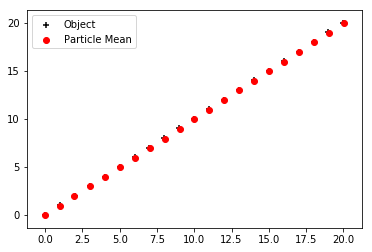

Final location error =  0.047750971613814246
Final variance in particles =  [1.81753553e-27 9.89547120e-27]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import uniform
from numpy.random import randn
from scipy.stats import norm

def run_linear_particle_filter(number_of_particles = 1000,
                               number_of_iterations = 20,
                               initial_particle_x_range = [-1,1], 
                               initial_particle_y_range = [-1,1],
                               initial_object_location = [0,0],
                               object_location_change = [1,1],
                               sensor_std = .1,
                               particle_std = .1):
    '''
    Run particle filter created by Kevin Minors
    
    PARAMETERS
     - number_of_particles:       Number of particles in filter
     - number_of_iterations:      Number of iterations in filter
     - initial_particle_x_range:  Initial x range for particles
     - initial_particle_y_range:  Initial y range for particles
     - initial_object_location:   Initial location of object
     - object_location_change:    Change in object location per step
     - sensor_std:                Standard deviation for sensor
     - particle_std:              Standard deviation for particles
        
    DESCRIPTION
    A particle filter created to estimate the location of 
    an object with linear motion. There is uncertainty in 
    the system behaviour when we move the particles and 
    there is uncertainty in the sensor when we measure
    the distance between particles and the object. 
    '''
    
    # Create an empty array for the location of each particle,
    # storing x coordinates in column 0, y coordinates 
    # in column 1
    particle_locations = np.empty((number_of_particles, 2))
    
    # Distribute x and y coordinates uniformly over
    # x range and y range
    particle_locations[:, 0] = uniform(initial_particle_x_range[0], 
                              initial_particle_x_range[1], 
                              size = number_of_particles)
    
    particle_locations[:, 1] = uniform(initial_particle_y_range[0], 
                              initial_particle_y_range[1], 
                              size = number_of_particles)

    # Set particle weights
    particle_weights = np.zeros(number_of_particles)
    
    # Create array for the mean of the particle locations
    object_location = initial_object_location
    
    particle_means = np.zeros((number_of_iterations+1,2))
    object_locations = np.zeros((number_of_iterations+1,2))
    
    particle_means[0,:] = [object_location[0],object_location[1]]
    object_locations[0,:] = [object_location[0],object_location[1]]
    
    # Loop through time steps
    for iteration in range(number_of_iterations):
        
        # Move object
        object_location[0] += object_location_change[0]
        object_location[1] += object_location_change[1]
        object_locations[iteration+1,:] = [object_location[0],object_location[1]]
        
        # Move particles according to object 
        # dynamics
        particle_locations[:,0] += object_location_change[0] 
        + randn(number_of_particles)*particle_std
        particle_locations[:,1] += object_location_change[1] 
        + randn(number_of_particles)*particle_std
        
        # Update particle weights according to 
        # measurements 
        distance_between_particles_object = abs(
            np.linalg.norm(particle_locations - object_location, axis=1) 
                                             + randn(number_of_particles)*sensor_std)

        particle_weights.fill(1.)     
        particle_weights *= 1. / (distance_between_particles_object + 1.e-300)
        particle_weights /= sum(particle_weights)
        
        # Resample particles based on weights
        # Possibly add in if statement to only resample when weights are small enough
        random_offset = random.random()
        random_positions = [(x + random_offset)/number_of_particles 
                            for x in list(range(number_of_particles))]

        # Calculate where in the cumsum these 
        # random positions lie and pick that
        # particle to be sampled.
        cumulative_sum = np.cumsum(particle_weights)/sum(particle_weights)

        particle_choices = np.zeros(number_of_particles, 'i')
        i, j = 0, 0
        while i < number_of_particles:
            if random_positions[i] < cumulative_sum[j]:
                particle_choices[i] = j
                i += 1
            else:
                j += 1
        
        particle_locations[:] = particle_locations[particle_choices]
        particle_weights[:] = particle_weights[particle_choices]
            
        # Calculate mean and variance of 
        # particles
        mean = np.average(particle_locations, weights=particle_weights, axis=0)
        var  = np.average((particle_locations - mean)**2, weights=particle_weights, axis=0)
        
        # Record particle locations  
        particle_means[iteration+1,:] = [mean[0],mean[1]]
        
    # Plot particle means and object locations
    plt.figure()
    plt.scatter(object_locations[:,0], object_locations[:,1], color = 'k', marker = '+')
    plt.scatter(particle_means[:,0], particle_means[:,1], color = 'r', marker = 'o')
    plt.legend(['Object', 'Particle Mean'])
    plt.show()
    
    print('Final location error = ', np.linalg.norm(mean - object_location, axis=0))
    print('Final variance in particles = ', var)

run_linear_particle_filter()

Detangling the particle filter from the example proved more difficult than expected. Many of the problems I faced initially doing this was not from the particle filter itself but from the underlying model and the communication between the two. 

Once I finished this stage of the particle filter and model, I then upgraded the underlying model to include nonlinear movement. These updates made the underlying model closer to the actual model we were working with. Then, we wanted to take it one step further so that the particle filter only interacts with the underlying model through a ‘step’ function that increments the underlying model forward in time. When this step function is called on the base model or a particle, it increments them by one time step. This way, there is very little interaction between the underlying model and the particle filter so the particle filter can easily be attached to a different underlying model. The only requirement is that the model has a ‘step’ function. 

Below is the code for a particle filter estimating the location of an object moving with a step function and matrix transition function. 

## Particle Filter with a step function and matrix transition

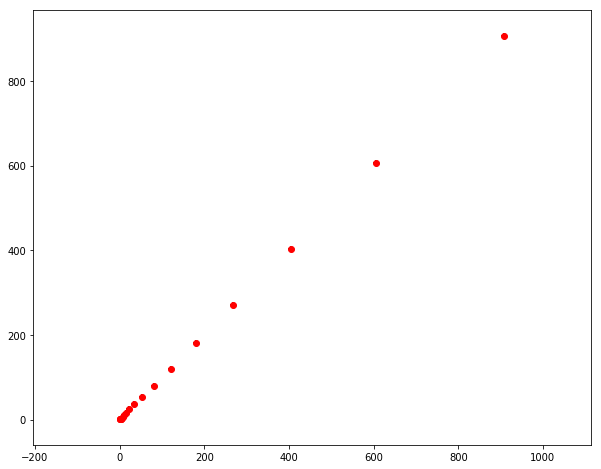

Final location error =  0.1053703991747064
Final std in particle location =  [0.35683619 0.43830442]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from numpy.random import uniform
from numpy.random import randn
from scipy.stats import norm

def step(state):
    '''
    Step function
    
    PARAMETERS
     - model_state:    The state of the system to be incremented by one time step
    
    DESCRIPTION
    A step function to increment the state by one time step. Depending on the
    dimension of the system, the function increments using different matrices.
    The state is multiplied by the transition matrix and then some randomness
    is added.
    
    Returns the new state of the system.
    '''
    dimension = len(state)
    
    if dimension == 3:
        state_transition = [[0.3,-0.4,0.1],
                            [-0.6,.8,-.6],
                            [0.7,-0.1,0.1]]
    elif dimension == 2:
        state_transition = [[1,.5],
                            [.5,1]]
    
    state_std = 1
    state_noise = randn(dimension)
    
    return np.matmul(state_transition, state) + state_noise*state_std

def run_step_particle_filter(initial_model_state = [1,1],
                             number_of_particles = 1000,
                             number_of_iterations = 20,
                             initial_particle_distribution_std = 1,
                             particle_model_behaviour_std = .1):
    '''
    Run particle filter with step function
    
    PARAMETERS
     - initial_model_state:    Initial state of the model
     
    DESCRIPTION
    A particle filter created to estimate the location of 
    an object with linear or nonlinear motion. There is uncertainty in 
    the system behaviour when we move the particles and 
    there is uncertainty in the sensor when we measure
    the distance between particles and the object. 
    '''
    dimensions = len(initial_model_state)
    model_state = initial_model_state
    
    particle_weights = np.ones(number_of_particles)
    particle_locations = np.empty((number_of_particles, dimensions))
    
    # set particle locations to initial model state with noise
    for dimension in range(dimensions):
        particle_locations[:,dimension] = (initial_model_state[dimension] 
         + initial_particle_distribution_std*randn(number_of_particles))
    
    # set mean
    particle_means = np.zeros((number_of_iterations, dimensions))
    mean = np.average(particle_locations, weights=particle_weights, axis=0)
    particle_means[0,:] = mean[:]

    plt.figure()
    plt.scatter(model_state[0], model_state[1], color = 'k', marker = '+')
    
    for iteration in range(number_of_iterations-1):
        # step model and particles
        model_state = step(model_state)
        for particle in range(number_of_particles):
            particle_locations[particle,:] = (step(particle_locations[particle,:]) 
                                      + randn(dimensions)*particle_model_behaviour_std)

        # calculate distance between state and particles and then weights
        distance = np.linalg.norm(particle_locations - model_state,axis=1)
        particle_weights = 1 / (distance + 1e-99)
        
        # resample particles using systematic resampling
        random_offset = random.random()
        random_partition = [ (x + random_offset) / number_of_particles 
                            for x in list(range(number_of_particles))]
        cumulative_sum = np.cumsum(particle_weights) / sum(particle_weights)

        i, j = 0, 0

        particle_indexes = np.zeros(number_of_particles, 'i')
        while i < number_of_particles:
            if random_partition[i] < cumulative_sum[j]:
                particle_indexes[i] = j
                i += 1 
            else:
                j += 1

        particle_locations[:] = particle_locations[particle_indexes]
        particle_weights[:] = particle_weights[particle_indexes]

        # save mean and variance of resampled particles
        mean = np.average(particle_locations,weights=particle_weights, axis=0)
        variance  = np.average((particle_locations- mean)**2,weights=particle_weights,axis=0)

        particle_means[iteration+1,:] = mean[:]
        plt.scatter(model_state[0], model_state[1], color = 'k', marker = '+')
        
    # Plot everything
    plt.scatter(particle_means[:,0], particle_means[:,1], color = 'r', marker = 'o')
    plt.gca().set_aspect('equal', 'datalim')
    plt.gcf().set_size_inches(10, 8)
    plt.show()
     
    print('Final location error = ', np.linalg.norm(mean - model_state, axis=0))
    print('Final std in particle location = ', variance**0.5)

run_step_particle_filter()

## Rewriting the particle filter for StationSim

While I was doing this initial work, another colleague was working on creating a Python version of StationSim [A, West et al. (2019) DUST: sspmm Accessed ONLINE 27/03/2019: http://github.com/urban-analytics/dust]. StationSim is an agent based model for people walking through a corridor from left to right. There are three doors on the left that people enter from and two doors on the right that people exit through. In the model, due to the behaviour and number of agents, crowding occurs.

Below is a picture of StationSim from its Java implementation.

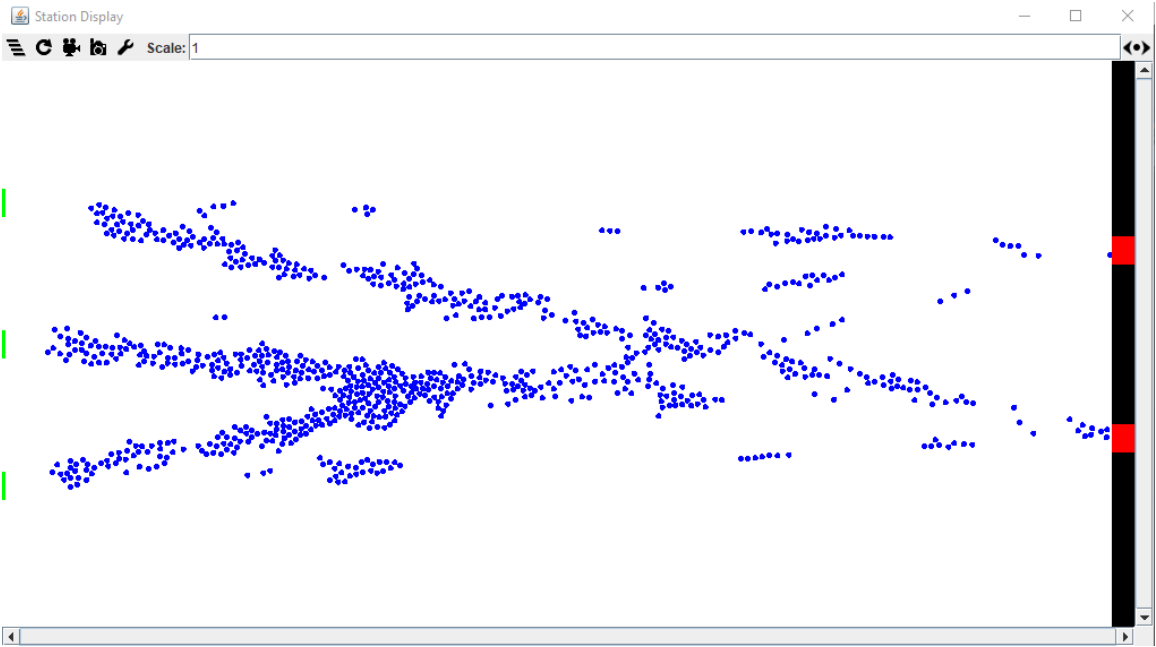

Here is some code to run the model, and figures illustrating how the crowd in the model develops. The code is available in full from the accompanying source file '[StationSim.py](./StationSim.py)'. (_The StationSim model is still under development, so for the most up to date version have a look in its main [development page](https://github.com/Urban-Analytics/dust/tree/master/Projects/StationSim-py)_).

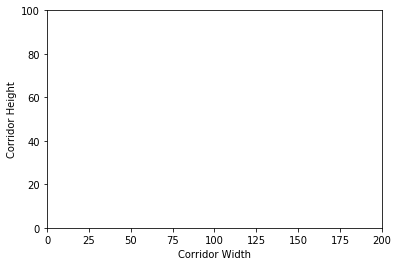

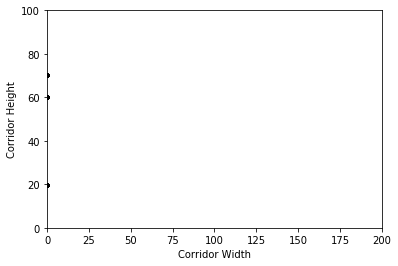

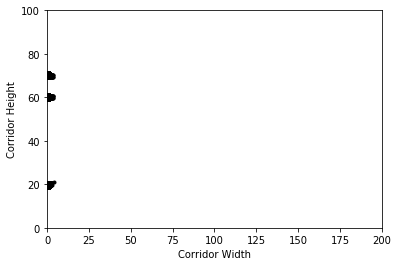

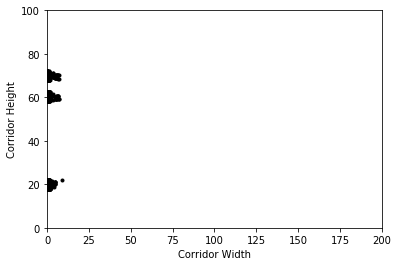

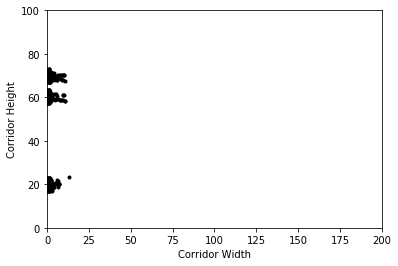

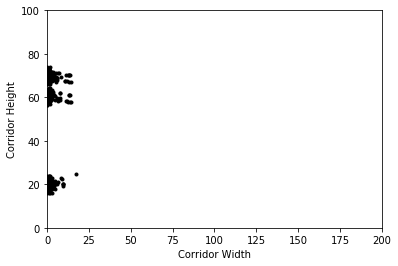

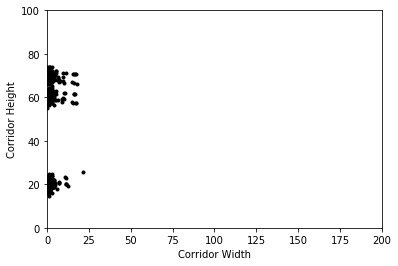

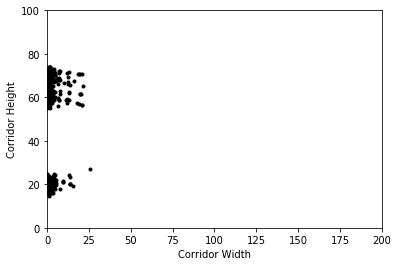

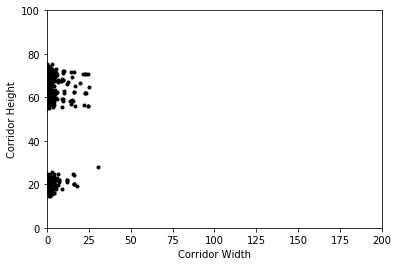

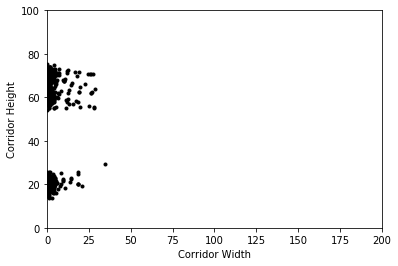

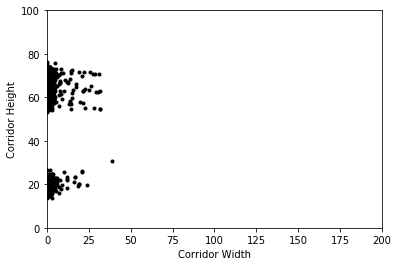

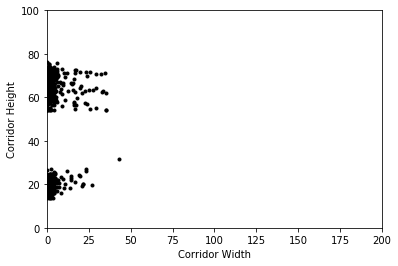

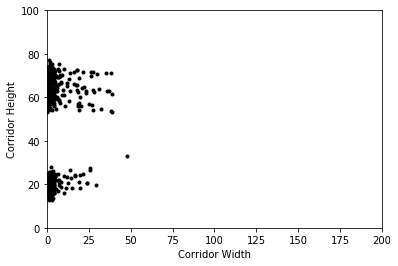

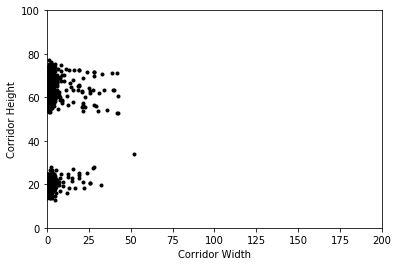

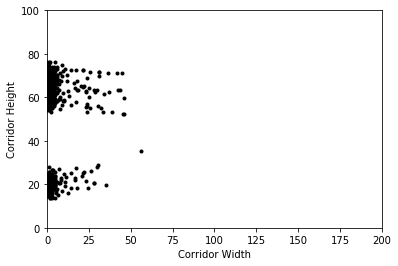

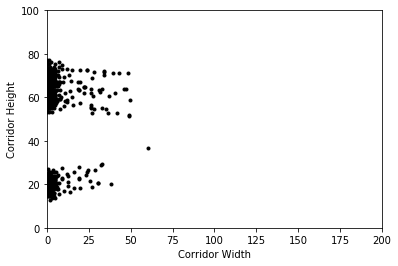

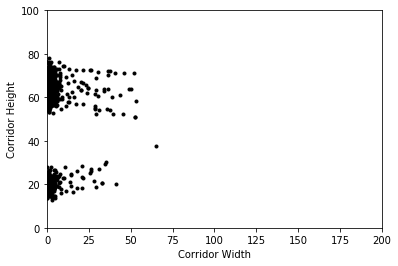

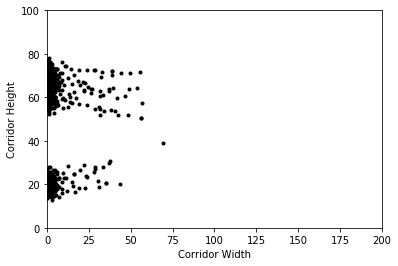

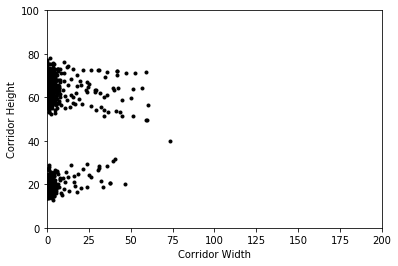

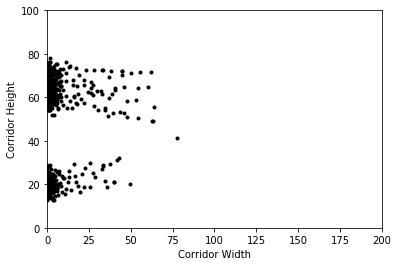

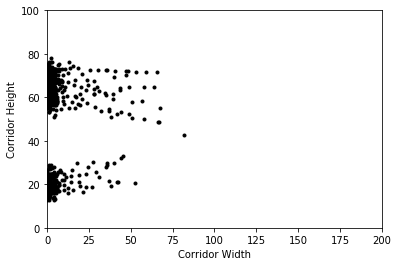

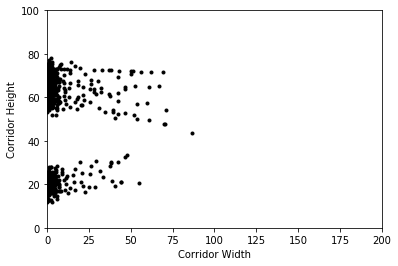

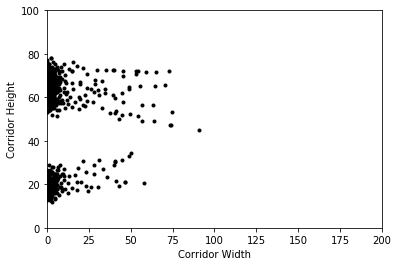

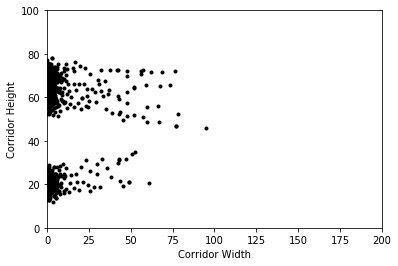

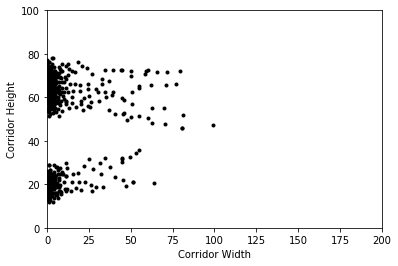

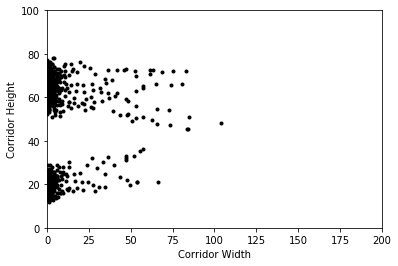

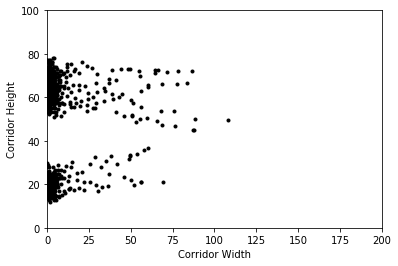

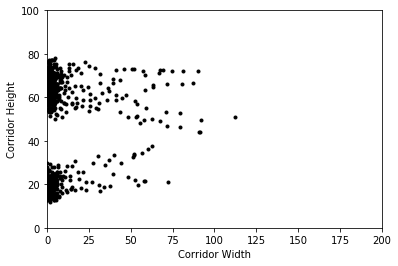

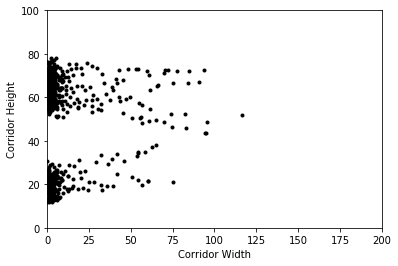

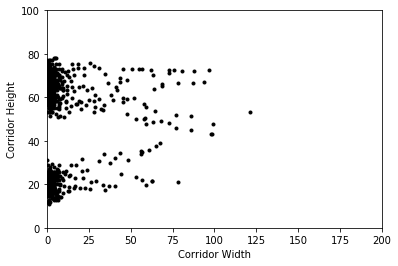

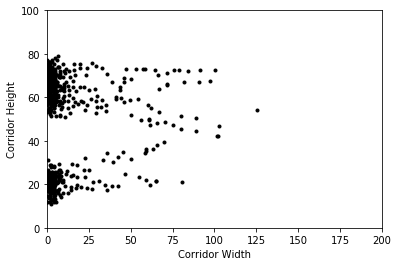

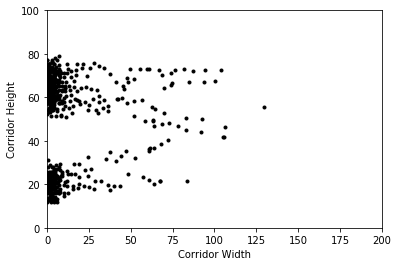

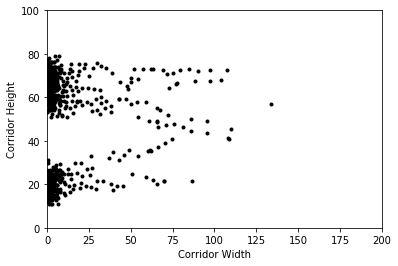

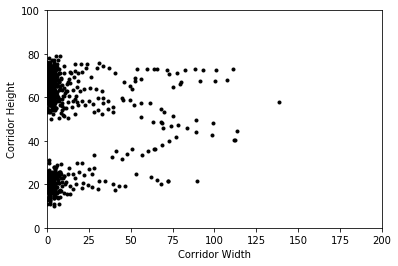

In [ ]:
import StationSim

# These are the parameters to configure the model
model_params = {
        'width': 200,
        'height': 100,
        'pop_total':700,
        'entrances': 3,
        'entrance_space': 2,
        'entrance_speed': .1,
        'exits': 2,
        'exit_space': 1,
        'speed_min': .1,
        'speed_desire_mean': 1,
        'speed_desire_std': 1,
        'separation': 2,
        'batch_iterations': 4000,
        'do_save': True,
        'do_ani': True,
        }

# Now run the model using these parameters:
StationSim.Model(model_params).batch()

Our goal is to use a particle filter on StationSim for data assimilation. Once StationSim was fully coded in Python, I added the particle filter to it using the step function in StationsSim. This took some time as we had to ensure the model and filter were communicating correctly and doing what we expected. This involved a lot of validation. 

Below is the code for the particle filter for StationSim. It doesn't work in the Jupyter Notebook as it needs to use multiprocessing (each particle runs as a separate process) but that wasn't supported at the time of writing)

## Particle filter for StationSim

In [ ]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from copy import deepcopy
from multiprocessing import Pool
import multiprocessing
from StationSim import Model

#%% PARTICLE FILTER

# Multiprocessing Methods
def initial_state(particle,self):
    """
    Set the state of the particles to the state of the
    base model.
    """
    self.states[particle,:] = self.base_model.agents2state()
    return self.states[particle]
    
def assign_agents(particle,self):
    """
    Assign the state of the particles to the 
    locations of the agents.
    """
    self.models[particle].state2agents(self.states[particle])
    return self.models[particle]

def step_particles(particle,self):
    """
    Step each particle model, assign the locations of the 
    agents to the particle state with some noise, and 
    then use the new particle state to set the location 
    of the agents.
    """
    self.models[particle].step()
    self.states[particle] = (self.models[particle].agents2state()
                           + np.random.normal(0, self.particle_std**2, 
                                                 size=self.states[particle].shape))
    self.models[particle].state2agents(self.states[particle])
    return self.models[particle], self.states[particle]

class ParticleFilter: 
    '''
    A particle filter to model the dynamics of the
    state of the model as it develops in time.
    '''

    def __init__(self, Model, model_params, filter_params):
        '''
        Initialise Particle Filter
            
        PARAMETERS
         - number_of_particles:     The number of particles used to simulate the model
         - number_of_iterations:    The number of iterations to run the model/particle filter
         - resample_window:         The number of iterations between resampling particles
         - agents_to_visualise:     The number of agents to plot particles for
         - particle_std:            The standard deviation of the noise added to particle states
         - model_std:               The standard deviation of the noise added to model observations
         - do_save:                 Boolean to determine if data should be saved and stats printed
         - do_ani:                  Boolean to determine if particle filter data should be animated
                                    and displayed
        
        DESCRIPTION
        Firstly, set all attributes using filter parameters. Set time and
        initialise base model using model parameters. Initialise particle
        models using a deepcopy of base model. Determine particle filter 
        dimensions, initialise all remaining arrays, and set initial
        particle states to the base model state using multiprocessing. 
        '''
        
        for key, value in filter_params.items():
            setattr(self, key, value)
        self.time = 0
        self.number_of_iterations = model_params['batch_iterations']
        self.base_model = Model(model_params)
        self.models = list([deepcopy(self.base_model) for _ in range(self.number_of_particles)])  
        self.dimensions = len(self.base_model.agents2state())
        self.states = np.zeros((self.number_of_particles, self.dimensions))
        self.weights = np.ones(self.number_of_particles)
        self.indexes = np.zeros(self.number_of_particles, 'i')
        if self.do_save:
            self.active_agents = []
            self.means = []
            self.mean_errors = []
            self.variances = []
            self.unique_particles = []
        
        self.states = np.array(pool.starmap(initial_state,list(zip(range(self.number_of_particles),[self]*self.number_of_particles))))
    
    def step(self):
        '''
        Step Particle Filter
        
        DESCRIPTION
        Loop through process. Predict the base model and particles
        forward. If the resample window has been reached, 
        reweight particles based on distance to base model and resample 
        particles choosing particles with higher weights. Then save
        and animate the data. When done, plot save figures.
        '''     
        while (self.time < self.number_of_iterations) & any([agent.active != 2 for agent in self.base_model.agents]):
            self.time += 1
            
            #if any([agent.active != 2 for agent in self.base_model.agents]):
#                print(self.time/self.number_of_iterations)
          #  print(self.number_of_iterations)
            self.predict()
            
            if self.time % self.resample_window == 0:
                self.reweight()
                self.resample()

            if self.do_save:
                self.save()
            if self.do_ani:
                self.ani()
              
        if self.plot_save:
            self.p_save()
            
        
        return max(self.mean_errors), np.average(self.mean_errors), max(self.variances), np.average(self.variances)
    
    def predict(self):
        '''
        Predict
        
        DESCRIPTION
        Increment time. Step the base model. Set self as a constant
        in step_particles and then use a multiprocessing method to step 
        particle models, set the particle states as the agent 
        locations with some added noise, and reassign the
        locations of the particle agents using the new particle
        states. We extract the models and states from the stepped
        particles variable.
        '''    
        self.base_model.step()

        stepped_particles = pool.starmap(step_particles,list(zip(range(self.number_of_particles),[self]*self.number_of_particles)))
            
        self.models = [stepped_particles[i][0] for i in range(len(stepped_particles))]
        self.states = np.array([stepped_particles[i][1] for i in range(len(stepped_particles))])
        
        return
    
    def reweight(self):
        '''
        Reweight
        
        DESCRIPTION
        Add noise to the base model state to get a measured state. Calculate 
        the distance between the particle states and the measured base model 
        state and then calculate the new particle weights as 1/distance. 
        Add a small term to avoid dividing by 0. Normalise the weights.
        '''
        measured_state = (self.base_model.agents2state() 
                          + np.random.normal(0, self.model_std**2, size=self.states.shape))
        distance = np.linalg.norm(self.states - measured_state, axis=1)
        self.weights = 1 / (distance + 1e-99)**2
        self.weights /= np.sum(self.weights)
        return

    def resample(self):
        '''
        Resample
        
        DESCRIPTION
        Calculate a random partition of (0,1) and then 
        take the cumulative sum of the particle weights.
        Carry out a systematic resample of particles.
        Set the new particle states and weights and then
        update agent locations in particle models using 
        multiprocessing methods.
        '''
        offset_partition = ((np.arange(self.number_of_particles) 
                             + np.random.uniform()) / self.number_of_particles)
        cumsum = np.cumsum(self.weights)
        i, j = 0, 0
        while i < self.number_of_particles:
            if offset_partition[i] < cumsum[j]:
                self.indexes[i] = j
                i += 1
            else:
                j += 1
                
        self.states[:] = self.states[self.indexes]
        self.weights[:] = self.weights[self.indexes]
        
        self.unique_particles.append(len(np.unique(self.states,axis=0)))

        self.models = pool.starmap(assign_agents,list(zip(range(self.number_of_particles),[self]*self.number_of_particles)))

        return

    def save(self):
        '''
        Save
        
        DESCRIPTION
        Calculate number of active agents, mean, and variance 
        of particles and calculate mean error between the mean 
        and the true base model state. Plot active agents,mean 
        error and mean variance. 
        '''    
        self.active_agents.append(sum([agent.active == 1 for agent in self.base_model.agents]))
        
        active_states = [agent.active == 1 for agent in self.base_model.agents for _ in range(2)]
        
        if any(active_states):
            mean = np.average(self.states[:,active_states], weights=self.weights, axis=0)
            variance = np.average((self.states[:,active_states] - mean)**2, weights=self.weights, axis=0)
            
            self.means.append(mean)
            self.variances.append(np.average(variance))

            truth_state = self.base_model.agents2state()
            self.mean_errors.append(np.linalg.norm(mean - truth_state[active_states], axis=0))
        
        return
    
    def p_save(self):
        '''
        Plot Save
        
        DESCRIPTION
        Plot active agents, mean error and mean variance. 
        '''    
        plt.figure(2)
        plt.plot(self.active_agents)
        plt.ylabel('Active agents')
        plt.show()
        
        plt.figure(3)
        plt.plot(self.mean_errors)
        plt.ylabel('Mean Error')
        plt.show()
        
        plt.figure(4)
        plt.plot(self.variances)
        plt.ylabel('Mean Variance')
        plt.show()
        
        plt.figure(5)
        plt.plot(self.unique_particles)
        plt.ylabel('Unique Particles')
        plt.show()
        
        print('Max mean error = ',max(self.mean_errors))
        print('Average mean error = ',np.average(self.mean_errors))
        print('Max mean variance = ',max(self.variances[2:]))
        print('Average mean variance = ',np.average(self.variances[2:]))

    
    def ani(self):
        '''
        Animate
        
        DESCRIPTION
        Plot the base model state and some of the 
        particles. Only do this if there is at least 1 active
        agent in the base model. We adjust the markersizes of
        each particle to represent the weight of that particle.
        We then plot some of the agent locations in the particles
        and draw lines between the particle agent location and 
        the agent location in the base model. 
        '''    
        if any([agent.active == 1 for agent in self.base_model.agents]):
    
            plt.figure(1)
            plt.clf()
            
            markersizes = self.weights
            if np.std(markersizes) != 0:
                markersizes *= 4 / np.std(markersizes)   # revar
            markersizes += 8 - np.mean(markersizes)  # remean

            particle = -1
            for model in self.models:
                particle += 1
                markersize = np.clip(markersizes[particle], .5, 8)
                for agent in model.agents[:self.agents_to_visualise]:
                    if agent.active == 1:
                        unique_id = agent.unique_id
                        if self.base_model.agents[unique_id].active == 1:     
                            locs = np.array([self.base_model.agents[unique_id].location, agent.location]).T
                            plt.plot(*locs, '-k', alpha=.1, linewidth=.3)
                            plt.plot(*agent.location, 'or', alpha=.3, markersize=markersize)
            
            for agent in self.base_model.agents:                
                if agent.active == 1:
                    plt.plot(*agent.location, 'sk',markersize = 4)
            
            plt.axis(np.ravel(self.base_model.boundaries, 'F'))
            plt.pause(1 / 4)


def single_run_particle_numbers():
    particle_num = 20
    runs = 1

    for i in range(runs):

        # Run the particle filter
        filter_params = {
            'number_of_particles': particle_num,
            'resample_window': 100,
            'agents_to_visualise': 2,
            'particle_std': 1,
            'model_std': 1,
            'do_save': True,
            'plot_save':False,
            'do_ani': False,
        }
        pf = ParticleFilter(Model, model_params, filter_params)
        print(i, particle_num, pf.step())

if __name__ == '__main__':
    __spec__ = None

# Pool object needed for multiprocessing
    pool = Pool(processes=multiprocessing.cpu_count())

    model_params = {
        'width': 200,
        'height': 100,
        'pop_total':700,
        'entrances': 3,
        'entrance_space': 2,
        'entrance_speed': .1,
        'exits': 2,
        'exit_space': 1,
        'speed_min': .1,
        'speed_desire_mean': 1,
        'speed_desire_std': 1,
        'separation': 2,
        'batch_iterations': 4000,
        'do_save': True,
        'do_ani': True,
        }
    if not True:
        Model(model_params).batch()
    else:
        single_run_particle_numbers()        
        

## Test particle filter

Once we were happy with the way they were running, we began discussing how we could examine the randomness in the model and in the filter. In the model, the agents move randomly up or down as they try and move around the other agents in their way. In the filter, randomness is added to the state of the particles to prevent particle collapse. Particle collapse occurs when only one particle is resampled during the resample step and so all particles have the same state. This provides a very poor estimate for the state of the base model so it should be avoided. Adding randomness to the particles ensures there is some diversity so it very unlikely only one particle is resampled. 

Below is a picture of particle collapse or particle impoverishment. 

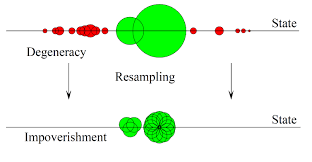

Randomness is also added to the observed state of the underlying model to reflect the uncertainty in real life sensors. In addition, we have parameters such as the number of particles and resample window that also affect how the particle filter behaves. While examining how these different parameters affect the filter, we realised it was taking quite a long time. We then thought to consider multiprocessing. This would allow the code to run faster as different particles can be run simultaneously rather than one at a time. 

Below are pictures of tasks being completed on a single thread and tasks being completed using multiprocessing. We can see multiprocessing is much faster. 

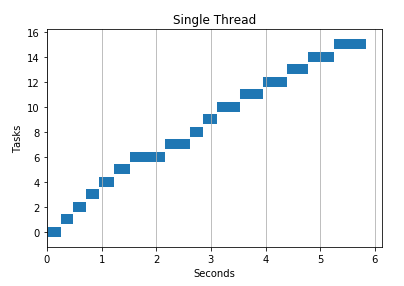

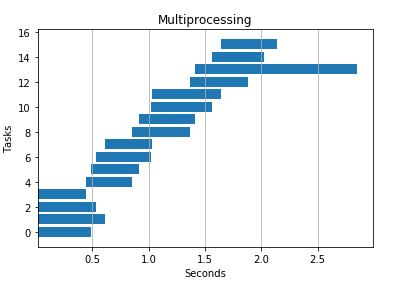

In addition, we were also looking into the literature to see what outputs are used to determine if a particle filter is behaving well. We found that the mean location of the particles, the variance of the particles, and the error between the mean location of the particles and the location of the underlying model are going metrics for the filter. One problem we then encountered was that the mean and variance was being calculated for particle agents that were no longer active in the StationSim simulation. Agents will have exited the corridor and be placed at some fixed location outside the boundary and they were still contributing to the mean and variance, which meant they were skewed. Another problem we found is that we could not do the multiprocessing we wanted to do in a Jupyter Notebook so we moved to writing python scripts directly, using the Spyder IDE. 

We then moved the testing to the University of Leeds Advanced Resarch Computing ([ARC3](https://arc.leeds.ac.uk/systems/arc3/)) high performance computing (HPC) environment. We started with a toy model of only 10 agents in the model to figure out how to actually use the supercomputer. We began by varying the number of particles, then the standard deviation for the particle noise, and finally the standard deviation for the observation noise. Once this was done, we scaled up the number of agents to 700 for the full model and started doing the same testing. 

After noticing there were still some bottlenecks and locks in the multiprocessing, we updated the filter to remove these and also step the particles continuously until the next observation. In terms of the results, this changed very little but in terms of speed, this made the code run a lot faster. I did some maths to work out how far an agent could move before hitting the next agent in front of it but the solver function is really slow so we decided not to use that. We then began running experiments to plot number of agents vs number of particles as a contour plot with the height given by the error in the particle filter. We expect the find areas where the particle filter works really well (few agents, many particles) and areas where it doesn’t work well (many agents, few particles). 

### Paper abstract for GISRUK 2019

http://www.newcastle.gisruk.org/

In recent years, cities have used the increase in data to make decisions that result in the city becoming more efficient and sustainable through automation. These cities are known as smart cities. One of the many important questions smart cities would like to answer is how do people behave? Being able to model the behaviour of a population in a city will prove very fruitful, as it will inform a variety of policy decisions. It is often very difficult to gain insight into human behaviour from a macroscopic point of view in real time.

One way to solve this issue is to use agent based models. These models attempt to simulate the behaviours of a population from a microscopic point of view by using simulated individuals, the 'agents'. The behaviour of the agents can be programmed to reflect the various dynamics of a particular city. One key component of agent based models is that there is some collective behaviour forming that is not programmed into individuals, known as 'emergence'. Agent based models are generally given some initial conditions and then they evolve forward in time independently from the real world environment they are simulating. This often results in the models diverging away from reality due to the limited accuracy of the initial conditions and model behaviour. To solve this problem, these models can use real time data from reality to update the state of the model in real time. This is known as data assimilation. New data is used to ensure the model continues to accurately reflect reality.

There are many ways to carry out data assimilation. One such method is known as a particle filter. Particle filters run numerous instances of the agent based model, known as 'particles', and allow them to develop forward in time. As new information is received about the true state of reality, the particle filter weights the particles based on how similar they are to the model state determined by the new information. Particles with a large weight are model runs that are very similar to the information received while particles with small weights are model runs that do not agree well with the new data. The particles are then resampled based on their weight, so that particles with a large weight are more likely to be chosen to be duplicated and particles with small weights are more likely to be discarded. In this way, the resampling results in particles with larger weights surviving and particles with small weights dying off. At this stage, the particles run forward in time until the next piece of information is received and the process continues.

This particle filter method allows the models to
run while also being able to update itself with
new data in real time, allowing the model to bet-
ter simulate reality over long periods of time.
One of the advantages of using particle filters
over other types of data assimilation is that it
can handle nonlinear dynamics, which applies
to a wide range of applications. One of the dis-
advantages is that it can be quite computation-
ally expensive as complicated models require a
significant number of particles in order to accu-
rately assimilate the new data. Problems with
particle filters include all particles collapsing to
one state due to a lack of diversity, known as
the degeneracy problem, and all particles fail-
ing to be similar to the new information due to
not enough particles being simulated.

The agent based model we are working on represents an environment like a corridor. In the model, agents enter the corridor from one side and walk through the corridor to exits on the other side. Just like people in real life, the agents have different speeds and different destinations. The emergence we find in this agent based model is crowding. As agents cross paths attempting to go to their exit and as slow agents block the path of fast agents, crowds form. We chose this model because it is simple enough for us to carry out data assimilation on it in a meaningful way and because it is complicated enough to have the emergent behaviour of crowding. In this case, as we do not have data from any corridor in particular, we use the model itself as our reality from which we receive new data. More details can be found on our Github page.

## Training / Workshops / Presentations

Netlogo practicals, Intro to GIS workshop, Mason tutorial, GIS for crime data training, ONS Safe Researcher training, QGIS workshop, ITS Big Data presentation, Python workshop, Workshop in Manchester, Tableau workshop, Climate meeting. Intern presentation, Data Carpentry workshop, Presentation training, Meeting Improbable in London. 